In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from bokeh.plotting import figure, show

from numba import jit, njit, prange

import mpmath
from mpmath import mpf, mpc


In [2]:
%load_ext autoreload
%autoreload 2
from mandel_algorithms import *

In [18]:
bound = 20

#'Alles'
#step = 0.001
#xarr = np.arange(-2., 1/2, step)
#yarr = np.arange(-1.5, 1.5, step)
#nmax = 50

'Leichter Zoom'
mid = -0.5, 0.6 #0.625
width = 0.4
step = 0.0001
xarr = np.arange(-width/2, +width/2, step)
yarr = np.arange(-width/2, +width/2, step)
nmax = 50
'''
'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116
xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
nmax = 1000


#'Sehr starker Zoom'
#mid = -.743643887037151, .131825904205330
#width = .000000000051299 
#xarr = np.linspace(mid[0]-width/2, mid[0]+width/2, 400)
#yarr = np.linspace(mid[1]-width/2, mid[1]+width/2, 400)
#nmax = 1000

#'Extrem'
mid = [mpf("-0.743643887035762993093485"), mpf("0.13182590421259917627678")] # wiki
width = 1. / 3.4426202e13
mid = [mpf('-0.74364388703576223'),        mpf('0.13182590421259555')] # meins
width = 1. / 3.4426202e13 /500
xarr = np.linspace(-width/2, width/2, 400)
yarr = np.linspace(-width/2, width/2, 400)
nmax = 5000'''

## Meshgrid berechnen
xarr, yarr = meshgrid(xarr, yarr)

Implementation mit Ableitung und boundary estimation<br>
$z_{i+1}(c) = z_i^2+c$ <br>
${z_{i+1}}'(c) = 2z_i z_i'+1$ <br>
$b(c) = \lim_{n \rightarrow \infty} |\frac{z_n}{{z_n}'}\ln(z_n)|$

In [20]:
# Performance Tests mit konstanter Einstellung

_step = 0.1
_xarr = np.arange(-2., 1/2, _step)
_yarr = np.arange(-1.5, 1.5, _step)
x_arr = np.repeat(_xarr[:, None], len(_yarr), -1)
y_arr = np.repeat(_yarr[None, :], len(_xarr), 0)
%timeit mandel1 = mandelbrot_mesh(_xarr, _yarr, 50)
%timeit mandel2 = mandelbrot(x_arr, y_arr, 50)
%timeit mandel3 = mandelbrot_cuda(x_arr, y_arr, 50)

55.7 µs ± 575 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
57.2 µs ± 778 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
mandel = mandelbrot(xarr, yarr, nmax)
mandel;

In [6]:
def predevelope_xy(xarr, yarr, series, coeff1, coeff2, coeff3):
    '''Uses the tailor expansion of a reference series to get a starting point for the mandelbrot iteration (without actually iterating -> fast)
    xarr, yarr: Relative coordinates, offset to the reference series
    series, der1 to der3: Reference series and its derivatives in c
    '''
    # Find out the maximal distance to the reference, w, and the iteration i for which the third order term becomes too big to have a good quadratic approximation
    w = np.max(xarr**2+yarr**2)**(1/2)
    for i in range(len(series)):
        if np.linalg.norm(coeff3[i]) * w**3 >= 1e-5:
            break
    
    n = i#-10
    d1 = coeff1[n,0] + 1j*coeff1[n,1]
    d2 = coeff2[n,0] + 1j*coeff2[n,1]
    zarr = xarr + 1j*yarr
    zarr = d1*zarr + d2*zarr**2
    print(n, d1*w, d2*w**2, coeff3[n,0]*w**3)
    return np.real(zarr), np.imag(zarr), n

In [6]:
xarr1, yarr1, n = predevelope_xy(xarr, yarr, series, coeff1, coeff2, coeff3)

NameError: name 'series' is not defined

### Implementation via reference series
Here we use a high precision number (mpf) to calculate a series of a single point in the middle of our image.
Once we have this series, all the other points around can be calculated by using this series as a reference.
Rather than iterating $z_i$, we are now iteration the difference $\Delta z_i = z_i - \tilde{z}_i$ to the reference series $\tilde{z}_i$.<br>
$\Delta z_{i+1}=2\tilde{z}_i\cdot \Delta z_i + \Delta c$<br>
Amazingly, for this difference series we only need normal precision number (single or double).

In [8]:
#mandel = mandelbrot(xarr, yarr, nmax) # 82ms (bei ca 400 iterationen)
# test vom verfahren mit entwicklung
n, series, coeff1, coeff2, coeff3 = f_highprecision(mpf(mid[0]), mpf(mid[1]), 15000)

#mandel = mandel_byreference(xarr-mid[0], yarr-mid[1], 500, series) # 103ms
#mandel = mandel_byreference_cuda(xarr-mid[0], yarr-mid[1], 15000, series) # 11.7
mandel = mandel_byreference_cuda(xarr, yarr, 15000, series)

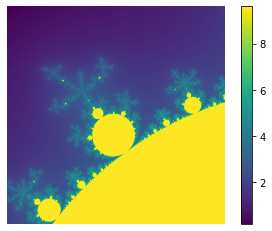

In [10]:
from plot_utils import *
plt.imshow(np.log(mandel.T[::-1]))
plt.colorbar()
plt.axis('off');

In [8]:
# Mit vorentwicklung durch taylorexpansion
#mandel = mandelbrot(xarr, yarr, nmax) # 82ms (bei ca 400 iterationen)
# test vom verfahren mit entwicklung
n, series, coeff1, coeff2, coeff3 = f_highprecision(mpf(mid[0]), mpf(mid[1]), 15000)

nstart, xstart, ystart = predevelope_xy(xarr, yarr, series, coeff1, coeff2, coeff3)
mandel = mandel_byreference_cuda(xarr, yarr, 15000, series, nstart, xstart, ystart)

## Zoom in

In [33]:
from tqdm import tqdm_notebook as tqdm

'Stärkerer Zoom'
mid = -0.743642, 0.13183
width = 0.000116 / 1000000 * 3
nmax = 1000

#'Sehr starker Zoom'
#mid = -.743643887037151, .131825904205330
#width = .000000000051299 
#nmax = 10000
#zoom = np.linspace(np.log(1.), np.log(width), 500)  # beim ersten
#zoom = np.exp(zoom)

'Extrem'
mid = [mpf('-0.74364388703576223'), mpf('0.13182590421259555')] # meins
width = 1. / 3.4426202e13 /500
nmax = 15000
zoom = np.linspace(np.log(1.), np.log(width), 3000)  # beim ersten
zoom = np.exp(zoom)

## Meshgrid berechnen
sx, sy = 200, 200
#sx, sy = 4096, 2160
#sx, sy = 2*4096, 2*2160
xarr = (np.arange(sx) - sx/2)/sx + 1e-12 # dont hit exactly the middle
yarr = (np.arange(sy) - sy/2)/sx + 1e-12
xarr, yarr = meshgrid(xarr, yarr)


##_, series = f_highprecision(mpf(mid[0]), mpf(mid[1]), nmax)
n, series, coeff1, coeff2, coeff3 = f_highprecision(mpf(mid[0]), mpf(mid[1]), 15000)


i = 0
mandels = []
for z in tqdm(zoom):
    _nmax = 1500 if z > 10**-5 else nmax
    xs = z*xarr
    ys = z*yarr
    m = mandel_byreference_cuda(xs, ys, _nmax, series)
    ##nstart, xstart, ystart = predevelope_xy(xs, ys, series, coeff1, coeff2, coeff3)  # mit vorentwicklung durch taylorexpansion
    ##m = mandel_byreference_cuda(xs, ys, 15000, series, nstart, xstart, ystart)

    #mandels += [m]
    m = downscale_gray(m, 2)
    plt.imsave('F:/$Daten/vidcaptures/mandelbrot_set/frame%05d.png' % i, np.log(m.T[::-1]), cmap='viridis')
    i += 1

KeyboardInterrupt: 

In [9]:
for m in mandels[::300]:
    plt.imshow(np.log(m.T[::-1]), cmap='viridis')
    plt.colorbar()
    plt.axis('off')
    plt.show()

NameError: name 'mandels' is not defined

### Entwicklung zweier Punkte

OverflowError: (34, 'Result too large')

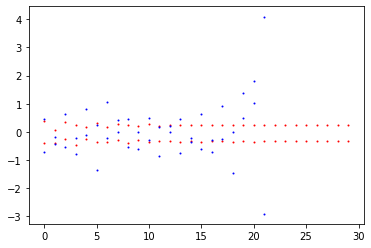

In [14]:

'Leichter Zoom'
mid = -0.5, 0.6 #0.625
width = 0.4
step = 0.0001
xarr = np.arange(mid[0]-width/2, mid[0]+width/2, step)
yarr = np.arange(mid[1]-width/2, mid[1]+width/2, step)
nmax = 50

p1 = (mid[0] + width/4, mid[1] - width/2)
p2 = (mid[0] - width/2, mid[1] - width/3)

c1_re, c1_im = p1
z1_re, z1_im = 0, 0
c2_re, c2_im = p2
z2_re, z2_im = 0, 0
for i in range(nmax):
    z1_re, z1_im = z1_re**2 - z1_im**2 + c1_re, 2*z1_re*z1_im + c1_im
    z2_re, z2_im = z2_re**2 - z2_im**2 + c2_re, 2*z2_re*z2_im + c2_im
    if i%1 == 0:
        if z1_re**2 + z1_im**2 < 10**2:
            plt.scatter(i, z1_re, c='r', s=1)
            plt.scatter(i, z1_im, c='r', s=1)
        if z2_re**2 + z2_im**2 < 10**2:
            plt.scatter(i, z2_re, c='b', s=1)
            plt.scatter(i, z2_im, c='b', s=1)

### Auswertung boundary estimation
Es ist nützlich, fürs plotten den Wert durch ein Polynom zu schicken, sodass die Werte nahe null hervorgehoben werden.

In [1]:
# Implementation mit Ableitung und boundary estimation
# Formel ist: 
@jit
def boundary(cx, cy, nmax):
    'Gibt die boundary estimation zurück'
    c = cx+cy*1j
    z = 0.  # z_i(c), wobei i iteriert wird
    zp = 0. # z_i'(c)
    for n in range(nmax):
        zp = 2*z*zp + 1.
        z = z**2 + c
        if z.real**2+z.imag**2 > bound:
            break
    return max(abs(z/zp)*ln(abs(z)+1e-8), 0)

@jit
def mandel_boundary(xarr, yarr, nmax):
    'Berechnet für 2D Array die boundary estimation'
    mandel = np.empty((len(xarr), len(yarr)))
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            mandel[i,j] = boundary(xarr[i], yarr[j], nmax)
    return np.array(mandel)

NameError: name 'jit' is not defined

In [11]:
#b = mandel_boundary(xarr, yarr, 5*nmax)
bb = b/b.max()
bb = (1-bb)**32
#bb = b<b.max()/10000
#bb = (b/b.max()*10000)
plt.imshow(bb.T[::-1])#, vmax=1.)

NameError: name 'b' is not defined

In [11]:
# plot in bokeh
fig = figure()
fig.image([mandel.T], xarr.min(), yarr.min(), xarr.max()-xarr.min(), yarr.max()-yarr.min())
show(fig)      

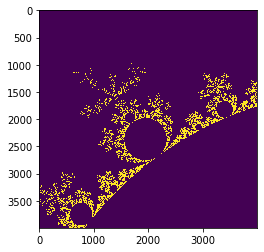

In [72]:
# Automatische Suche nach Interessantem Material durch Gradienten
aa = np.log(mandel.T[::-1])
ax = aa[2:,2:]-aa[:-2,2:]
ay = aa[2:,2:]-aa[2:,:-2]

plt.imshow(ax**2+ay**2>.1)
#plt.colorbar()

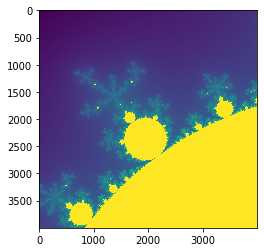

In [73]:
plt.imshow(aa)